### MIE1622 - Assignment 1 - Bryan Tarras, 998853600

This notebook presents the commented and cleaned code for the submission of Assignment 1 excludgin the modifications in part 3 for the inclusion of an alternate version to the equally weighted portfolio. Please refer to the inlcuded report (word file in submission) that details the analysis associated with the results of this notebook.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math

import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import cplex

In [2]:
weights_array = [0.05]*20
print (weights_array)

[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]


In [3]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    return (x_optimal, cash_optimal)

In [4]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    weights_array = [0.05]*20
    x_optimal = np.dot(weights_array, np.dot(x_init,cur_prices))
    x_optimal = np.divide(x_optimal, cur_prices) 
    x_optimal = np.floor(x_optimal)
    
    #Compute the net_change in positions from the min_variance reccomended positions to the last positions 
    net_change = x_init-x_optimal
    
    #Calculate the change in price associated with this change
    net_change_price = np.dot(net_change,cur_prices)
    
    #Set cash account equal to the sum of the net of the price changes
    cash_optimal = np.sum(net_change_price)
    #print (cash_optimal)
    
    #Add previous cash_optimal value to the current cash_optimal value (linking previous periods cash amount to this period)
    cash_optimal = cash_optimal + cash_init
    
    
    ##################### CASH VALIDATION SECTION #####################
    
    #What to do if Cash_Optimal is 0?
    #Revert as many times as possible most bought current positions to the previous position until Cash Account > 0
    #Doing so would reduce the biggest subtraction from your cash_account, thus bringing it to positive the quickest
    counter = 0
    loop_break = 0
    if cash_optimal < 0:
        #Loop Condition Variable
        while loop_break == 0:
            #Sort positions based on greatest greatest change (most negative) to least (most positive)
            #since net_change is defined as intial_positions - current_suggested_positions, the most bought assets will
            #be the most negative and the one's we want to rectify first
            position_sort = np.argsort(net_change)
            #update cash_account such that reverted positions have their cash value of the transaction added back to the 
            #cash account
            cash_optimal = cash_optimal + np.absolute(net_change[position_sort[counter]]*cur_prices[position_sort[counter]])
            #Update the position array with the new positions
            x_optimal[position_sort[counter]] = x_init[position_sort[counter]]
            #Update counter so if cash_optimal is still negative the loop will continue to the next most bought asset
            #and revert its position
            counter = counter + 1
            #loop break condition is when cash_optimal is greater than 0
            if cash_optimal > 0:
                loop_break = 1
    
    #Recalculate Net-Change as we have potentially changed the positions based on the above loop
    net_change = x_init-x_optimal
    
    #Transaction costs for the required transactions above to get to an equally weighted portfolio
    transaction_cost = np.sum(np.dot(np.absolute(net_change),cur_prices)*0.005)
    cash_optimal = cash_optimal - transaction_cost
    
    #Cash account may now be negative due to the addition of transaction costs, so this needs to be corrected
    #Similar to above revert most bought position to previous position and repeat until cash_optimal > 0
    counter_2 = 0
    loop_break_2 = 0
    if cash_optimal < 0:
        while loop_break_2 == 0:
            position_sort_2 = np.argsort(net_change)
            cash_optimal = cash_optimal + np.absolute(net_change[position_sort_2[counter_2]]*cur_prices[position_sort_2[counter_2]]*1.005)
            x_optimal[position_sort_2[counter_2]] = x_init[position_sort_2[counter_2]]
            counter_2 = counter_2 + 1
            if cash_optimal > 0:
                loop_break_2 = 1
    
    #Next up Optimize the Cash Account as reverting positions means we have massive values in the Cash Account
    #this is obviously undesirable as it could be invested in
    
    #First Possible Scenario, Cash Account is positive and no adjustments to the positions from min_variance 
    #reccomended positions was required
    if (cash_optimal > 0 and counter == 0 and counter_2 == 0):
        extra_purchase = np.floor(np.divide(cash_optimal,(np.amin(cur_prices)*1.005)))
        #need to find the position of the min price asset and add the extra purchase to this number of shares
        position = np.argmin(cur_prices)
        x_optimal[position] = x_optimal[position] + extra_purchase
        cash_optimal = cash_optimal - np.dot(extra_purchase,np.amin(cur_prices))
        #...Need to add in transaction costs here as well...
        transaction_cost_3 = np.sum(np.dot(extra_purchase,cur_prices[position])*0.005)
        cash_optimal = cash_optimal - transaction_cost_3
    
    #Second Possible Scenario, Cash Account is positive and adjustments to the positions from min_variance
    #reccomended positions was required as the price of shares bought > price of shares sold
    elif (cash_optimal > 0 and counter > 0 and counter_2 < 1):        
        #Look to invest as many times as possible into the asset's position that was reverted back to previous position
        #in order to allow for cash positive account. Doing so preserves the reccomended positions as much as possible
        extra_purchase = np.floor(cash_optimal/((cur_prices[position_sort[counter-1]])*1.005))
        #Add these extra purchases to the array holding the positions
        x_optimal[position_sort[counter-1]] = x_optimal[position_sort[counter-1]] + extra_purchase
        #Update cash account such that the extra positions and their associated transaction costs are subtracted from
        #the cash account
        cash_optimal = cash_optimal - extra_purchase*cur_prices[position_sort[counter-1]]*1.005
    
    #Third Possible Scenario, Cash Account is positive and adjustments to the positions from min_variance
    #reccomended positions was required as the transaction fee of 0.5% for all transactions resulted in negative
    #cash account
    elif (cash_optimal > 0 and counter_2 > 0 and counter < 1):
        #Look to invest as many times as possible into the asset's position that was reverted back to previous position
        #in order to allow for cash positive account. Doing so preserves the reccomended positions as much as possible
        extra_purchase = np.floor(cash_optimal/((cur_prices[position_sort_2[counter_2-1]])*1.005))
        #Add these extra purchases to the array holding the positions
        x_optimal[position_sort_2[counter_2-1]] = x_optimal[position_sort_2[counter_2-1]] + extra_purchase
        #Update cash account such that the extra positions and their associated transaction costs are subtracted from
        #the cash account
        cash_optimal = cash_optimal - extra_purchase*cur_prices[position_sort_2[counter_2-1]]*1.005
    return (x_optimal, cash_optimal)

In [5]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    
    #Define Cplex
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    n = len(x_init)
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    
    A = []
    for k in range(n):
        A.append([[0],[1.0]])

    var_names = ["w_%s" % i for i in range(1,n+1)]
    
    #Right hand constraint is equal to 1
    #Lower bound handles the case of weights needing to be greater than 0
    cpx.linear_constraints.add(rhs=[1.0], senses="E")

    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    
    cpx.objective.set_quadratic(Qmat)
    
    cpx.parameters.threads.set(4)
    
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    cpx.solve()
    
    #Get Solution Weights
    w_cur = cpx.solution.get_values()
    
    #Store in an weights array
    weights_array = [0.00]*20
    weights_array = w_cur
    weights_array = np.asarray(weights_array)
    
    #Compute the positions of the assets in the portfolio based on the Minimum Variance weights identified above
    x_optimal = weights_array*np.dot(x_init,cur_prices)
    x_optimal = np.divide(x_optimal, cur_prices) 
    x_optimal = np.floor(x_optimal)
    
    #Compute the net_change in positions from the min_variance reccomended positions to the last positions 
    net_change = x_init-x_optimal
    
    #Calculate the change in price associated with this change
    net_change_price = np.dot(net_change,cur_prices)
    
    #Set cash account equal to the sum of the net of the price changes
    cash_optimal = np.sum(net_change_price)
    #print (cash_optimal)
    
    #Add previous cash_optimal value to the current cash_optimal value (linking previous periods cash amount to this period)
    cash_optimal = cash_optimal + cash_init
    
    
    ##################### CASH VALIDATION SECTION #####################
    
    #What to do if Cash_Optimal is 0?
    #Revert as many times as possible most bought current positions to the previous position until Cash Account > 0
    #Doing so would reduce the biggest subtraction from your cash_account, thus bringing it to positive the quickest
    counter = 0
    loop_break = 0
    if cash_optimal < 0:
        #Loop Condition Variable
        while loop_break == 0:
            #Sort positions based on greatest greatest change (most negative) to least (most positive)
            #since net_change is defined as intial_positions - current_suggested_positions, the most bought assets will
            #be the most negative and the one's we want to rectify first
            position_sort = np.argsort(net_change)
            #update cash_account such that reverted positions have their cash value of the transaction added back to the 
            #cash account
            cash_optimal = cash_optimal + np.absolute(net_change[position_sort[counter]]*cur_prices[position_sort[counter]])
            #Update the position array with the new positions
            x_optimal[position_sort[counter]] = x_init[position_sort[counter]]
            #Update counter so if cash_optimal is still negative the loop will continue to the next most bought asset
            #and revert its position
            counter = counter + 1
            #loop break condition is when cash_optimal is greater than 0
            if cash_optimal > 0:
                loop_break = 1
    
    #Recalculate Net-Change as we have potentially changed the positions based on the above loop
    net_change = x_init-x_optimal
    
    #Transaction costs for the required transactions above to get to an equally weighted portfolio
    transaction_cost = np.sum(np.dot(np.absolute(net_change),cur_prices)*0.005)
    cash_optimal = cash_optimal - transaction_cost
    
    #Cash account may now be negative due to the addition of transaction costs, so this needs to be corrected
    #Similar to above revert most bought position to previous position and repeat until cash_optimal > 0
    counter_2 = 0
    loop_break_2 = 0
    if cash_optimal < 0:
        while loop_break_2 == 0:
            position_sort_2 = np.argsort(net_change)
            cash_optimal = cash_optimal + np.absolute(net_change[position_sort_2[counter_2]]*cur_prices[position_sort_2[counter_2]]*1.005)
            x_optimal[position_sort_2[counter_2]] = x_init[position_sort_2[counter_2]]
            counter_2 = counter_2 + 1
            if cash_optimal > 0:
                loop_break_2 = 1
    
    #Next up Optimize the Cash Account as reverting positions means we have massive values in the Cash Account
    #this is obviously undesirable as it could be invested in
    
    #First Possible Scenario, Cash Account is positive and no adjustments to the positions from min_variance 
    #reccomended positions was required
    if (cash_optimal > 0 and counter == 0 and counter_2 == 0):
        extra_purchase = np.floor(np.divide(cash_optimal,(np.amin(cur_prices)*1.005)))
        #need to find the position of the min price asset and add the extra purchase to this number of shares
        position = np.argmin(cur_prices)
        x_optimal[position] = x_optimal[position] + extra_purchase
        cash_optimal = cash_optimal - np.dot(extra_purchase,np.amin(cur_prices))
        #...Need to add in transaction costs here as well...
        transaction_cost_3 = np.sum(np.dot(extra_purchase,cur_prices[position])*0.005)
        cash_optimal = cash_optimal - transaction_cost_3
    
    #Second Possible Scenario, Cash Account is positive and adjustments to the positions from min_variance
    #reccomended positions was required as the price of shares bought > price of shares sold
    elif (cash_optimal > 0 and counter > 0 and counter_2 < 1):        
        #Look to invest as many times as possible into the asset's position that was reverted back to previous position
        #in order to allow for cash positive account. Doing so preserves the reccomended positions as much as possible
        extra_purchase = np.floor(cash_optimal/((cur_prices[position_sort[counter-1]])*1.005))
        #Add these extra purchases to the array holding the positions
        x_optimal[position_sort[counter-1]] = x_optimal[position_sort[counter-1]] + extra_purchase
        #Update cash account such that the extra positions and their associated transaction costs are subtracted from
        #the cash account
        cash_optimal = cash_optimal - extra_purchase*cur_prices[position_sort[counter-1]]*1.005
    
    #Third Possible Scenario, Cash Account is positive and adjustments to the positions from min_variance
    #reccomended positions was required as the transaction fee of 0.5% for all transactions resulted in negative
    #cash account
    elif (cash_optimal > 0 and counter_2 > 0 and counter < 1):
        #Look to invest as many times as possible into the asset's position that was reverted back to previous position
        #in order to allow for cash positive account. Doing so preserves the reccomended positions as much as possible
        extra_purchase = np.floor(cash_optimal/((cur_prices[position_sort_2[counter_2-1]])*1.005))
        #Add these extra purchases to the array holding the positions
        x_optimal[position_sort_2[counter_2-1]] = x_optimal[position_sort_2[counter_2-1]] + extra_purchase
        #Update cash account such that the extra positions and their associated transaction costs are subtracted from
        #the cash account
        cash_optimal = cash_optimal - extra_purchase*cur_prices[position_sort_2[counter_2-1]]*1.005
    
    #Return optimal positions and cash value
    return (x_optimal, cash_optimal)

In [6]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    
    #Pad the Q array to get Q~
    Q_2 = np.pad(Q, ((0,1),(0,1)), 'constant')

    #Define Cplex Model
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    n = len(x_init)
    
    #Set constants, lower and upper bounds
    c  = [0.0] * (n+1)
    lb = [0.0] * (n+1)
    ub = [cplex.infinity] * (n+1)
    
    #Risk Free Rate (divide by 252 as rate is shown as an annual rate)
    r_rf = (1+0.025)**(1/252)-1
    
    #Setup A array that holds linear constraints
    A = []
    for k in range(n+1):
        if (k < 20):
            A.append([[0,1],[1,((mu[k]-r_rf))]])
        else:
            #Append kappa as the last column in the sparse matrix
            A.append([[0,1],[-1,0]])

    #Setup up variable names
    var_names = ["w_%s" % i for i in range(1,n+2)]
    
    #Set RHS constraints
    cpx.linear_constraints.add(rhs=[0,1], senses="EE")

    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    Qmat = [[list(range(n+1)), list(2*Q_2[k,:])] for k in range(n+1)]
    
    cpx.objective.set_quadratic(Qmat)
        
    cpx.parameters.threads.set(6)
    
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    #Solve optimization probelm
    cpx.solve()
    
    #Store y values in an array
    y = cpx.solution.get_values()
    
    #Kappa is the last entry in the list
    kappa = y[-1]
    #Everything else is a y value
    y_list = y[:20]
    
    #Convert list to float array
    y_array = np.asarray(y_list)
    y_array = y_array.astype(float)
    
    #Compute the w_maxsharpe values
    w_maxsharpe = y_array/kappa
    
    #Store in an weights array as per previous formatting in Min_Variance function
    weights_array = [0.00]*20
    weights_array = w_maxsharpe
    
    #Compute the positions of the assets in the portfolio based on the Minimum Variance weights identified above
    x_optimal = weights_array*np.dot(x_init,cur_prices)
    x_optimal = np.divide(x_optimal, cur_prices) 
    x_optimal = np.floor(x_optimal)
    
    #Compute the net_change in positions from the min_variance reccomended positions to the last positions 
    net_change = x_init-x_optimal
    
    #Calculate the change in price associated with this change
    net_change_price = np.dot(net_change,cur_prices)
    
    #Set cash account equal to the sum of the net of the price changes
    cash_optimal = np.sum(net_change_price)
    #print (cash_optimal)
    
    #Add previous cash_optimal value to the current cash_optimal value (linking previous periods cash amount to this period)
    cash_optimal = cash_optimal + cash_init
    
    
    ##################### CASH VALIDATION SECTION #####################
    
    #What to do if Cash_Optimal is 0?
    #Revert as many times as possible most bought current positions to the previous position until Cash Account > 0
    #Doing so would reduce the biggest subtraction from your cash_account, thus bringing it to positive the quickest
    counter = 0
    loop_break = 0
    if cash_optimal < 0:
        #Loop Condition Variable
        while loop_break == 0:
            #Sort positions based on greatest greatest change (most negative) to least (most positive)
            #since net_change is defined as intial_positions - current_suggested_positions, the most bought assets will
            #be the most negative and the one's we want to rectify first
            position_sort = np.argsort(net_change)
            #update cash_account such that reverted positions have their cash value of the transaction added back to the 
            #cash account
            cash_optimal = cash_optimal + np.absolute(net_change[position_sort[counter]]*cur_prices[position_sort[counter]])
            #Update the position array with the new positions
            x_optimal[position_sort[counter]] = x_init[position_sort[counter]]
            #Update counter so if cash_optimal is still negative the loop will continue to the next most bought asset
            #and revert its position
            counter = counter + 1
            #loop break condition is when cash_optimal is greater than 0
            if cash_optimal > 0:
                loop_break = 1
    
    #Recalculate Net-Change as we have potentially changed the positions based on the above loop
    net_change = x_init-x_optimal
    
    #Transaction costs for the required transactions above to get to an equally weighted portfolio
    transaction_cost = np.sum(np.dot(np.absolute(net_change),cur_prices)*0.005)
    cash_optimal = cash_optimal - transaction_cost
    
    #Cash account may now be negative due to the addition of transaction costs, so this needs to be corrected
    #Similar to above revert most bought position to previous position and repeat until cash_optimal > 0
    counter_2 = 0
    loop_break_2 = 0
    if cash_optimal < 0:
        while loop_break_2 == 0:
            position_sort_2 = np.argsort(net_change)
            cash_optimal = cash_optimal + np.absolute(net_change[position_sort_2[counter_2]]*cur_prices[position_sort_2[counter_2]]*1.005)
            x_optimal[position_sort_2[counter_2]] = x_init[position_sort_2[counter_2]]
            counter_2 = counter_2 + 1
            if cash_optimal > 0:
                loop_break_2 = 1
    
    #Next up Optimize the Cash Account as reverting positions means we have massive values in the Cash Account
    #this is obviously undesirable as it could be invested in
    
    #First Possible Scenario, Cash Account is positive and no adjustments to the positions from min_variance 
    #reccomended positions was required
    if (cash_optimal > 0 and counter == 0 and counter_2 == 0):
        extra_purchase = np.floor(np.divide(cash_optimal,(np.amin(cur_prices)*1.005)))
        #need to find the position of the min price asset and add the extra purchase to this number of shares
        position = np.argmin(cur_prices)
        x_optimal[position] = x_optimal[position] + extra_purchase
        cash_optimal = cash_optimal - np.dot(extra_purchase,np.amin(cur_prices))
        #...Need to add in transaction costs here as well...
        transaction_cost_3 = np.sum(np.dot(extra_purchase,cur_prices[position])*0.005)
        cash_optimal = cash_optimal - transaction_cost_3
    
    #Second Possible Scenario, Cash Account is positive and adjustments to the positions from min_variance
    #reccomended positions was required as the price of shares bought > price of shares sold
    elif (cash_optimal > 0 and counter > 0 and counter_2 < 1):        
        #Look to invest as many times as possible into the asset's position that was reverted back to previous position
        #in order to allow for cash positive account. Doing so preserves the reccomended positions as much as possible
        extra_purchase = np.floor(cash_optimal/((cur_prices[position_sort[counter-1]])*1.005))
        #Add these extra purchases to the array holding the positions
        x_optimal[position_sort[counter-1]] = x_optimal[position_sort[counter-1]] + extra_purchase
        #Update cash account such that the extra positions and their associated transaction costs are subtracted from
        #the cash account
        cash_optimal = cash_optimal - extra_purchase*cur_prices[position_sort[counter-1]]*1.005
    
    #Third Possible Scenario, Cash Account is positive and adjustments to the positions from min_variance
    #reccomended positions was required as the transaction fee of 0.5% for all transactions resulted in negative
    #cash account
    elif (cash_optimal > 0 and counter_2 > 0 and counter < 1):
        #Look to invest as many times as possible into the asset's position that was reverted back to previous position
        #in order to allow for cash positive account. Doing so preserves the reccomended positions as much as possible
        extra_purchase = np.floor(cash_optimal/((cur_prices[position_sort_2[counter_2-1]])*1.005))
        #Add these extra purchases to the array holding the positions
        x_optimal[position_sort_2[counter_2-1]] = x_optimal[position_sort_2[counter_2-1]] + extra_purchase
        #Update cash account such that the extra positions and their associated transaction costs are subtracted from
        #the cash account
        cash_optimal = cash_optimal - extra_purchase*cur_prices[position_sort_2[counter_2-1]]*1.005
        
    return (x_optimal, cash_optimal)

In [7]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

In [8]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

In [9]:
dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])

In [10]:
# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2014)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

In [11]:
# Remove datapoints for year 2014
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

In [12]:
# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

In [13]:
# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))


Initial portfolio value = $ 1000002.12



In [14]:
# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

In [15]:
print (w_init)

[0.23379949 0.01459197 0.06645986 0.         0.         0.
 0.         0.0939198  0.32798931 0.24308948 0.         0.
 0.         0.         0.         0.         0.02015009 0.
 0.         0.        ]


In [16]:
# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

In [17]:
# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025

In [18]:
# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio']
#N_strat = 4  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe]

In [19]:
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

In [20]:
all_prices = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

In [21]:
for period in range(1, N_periods+1):
    # Compute current year and month, first and last day of the period

    if dates_array[0, 0] == 15:
        cur_year  = 15 + math.floor(period/7)
    else:
        cur_year  = 2015 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
    
    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

    # Execute portfolio selection strategies
    for strategy in range(N_strat):

        # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]

        # Compute strategy
        
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
        
        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs

        ###################### Insert your code here ############################
        #FOR THE TA AND PROF
            #I have put the cash validation code in each function for the sake of debugging and keeping positional changes
            #within the functions themselves. Please refer to the portion of the functions which state:
            ##################### CASH VALIDATION SECTION #####################
                    
        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format(strategy_names[strategy], 
                                                                                        portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
      
    # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)

    # Plot results
    ###################### Insert your code here ############################
    #Store all prices across the strategies analyzed
    all_prices[strategy, period-1] = cur_prices
    #Refer to cells below for the plotted graphs


Period 1: start date 1/2/2015, end date 2/27/2015
  Strategy "Buy and Hold", value begin = $ 1000002.12, value end = $ 1043785.08
  Strategy "Equally Weighted Portfolio", value begin = $ 992883.20, value end = $ 1019578.34
  Strategy "Mininum Variance Portfolio", value begin = $ 991449.33, value end = $ 1015652.83
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990051.98, value end = $ 1007404.91

Period 2: start date 3/2/2015, end date 4/30/2015
  Strategy "Buy and Hold", value begin = $ 1045234.09, value end = $ 1069877.19
  Strategy "Equally Weighted Portfolio", value begin = $ 1030199.28, value end = $ 1010576.37
  Strategy "Mininum Variance Portfolio", value begin = $ 1022846.55, value end = $ 1013153.19
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1016819.87, value end = $ 1055098.54

Period 3: start date 5/1/2015, end date 6/30/2015
  Strategy "Buy and Hold", value begin = $ 1085647.24, value end = $ 1027659.63
  Strategy "Equally Weighted Portfolio

### Plotting the Weight Allocations for Minimum Variance and Max Sharpe Ratio Portfolios

In [22]:
#Setup a prices dataframe that stores the prices of each asset across the periods
df_prices = pd.DataFrame(all_prices[3][:], columns = ['Prices'])
df_prices.tail()

,Prices
7,"[52.580002, 13.09, 42.75, 718.8099980000001, 1..."
8,"[50.610001000000004, 13.62, 39.34, 698.210022,..."
9,"[51.16, 12.72, 30.18, 699.210022, 12.73, 37.99..."
10,"[57.59, 12.44, 22.879998999999998, 768.780029,..."
11,"[59.799999, 11.61, 19.700001, 783.609984999999..."


In [23]:
#Setup a positions dataframe that holds the positions for each portfolio across each period
df_positions = pd.DataFrame(x[0][:], columns = ['Buy and Hold']) 
df_positions['Equally Weighted Portfolio'] = x[1][:]
df_positions['Mininum Variance Portfolio'] = x[2][:]
df_positions['Maximum Sharpe Ratio Portfolio'] = x[3][:]
df_positions.tail()

,Buy and Hold,Equally Weighted Portfolio,Mininum Variance Portfolio,Maximum Sharpe Ratio Portfolio
7,"[5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500...","[933.0, 3750.0, 1148.0, 68.0, 4491.0, 1496.0, ...","[0.0, 0.0, 0.0, 158.0, 0.0, 0.0, 410.0, 0.0, 0...","[0.0, 0.0, 4848.0, 0.0, 0.0, 0.0, 0.0, 14460.0..."
8,"[5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500...","[1052.0, 3912.0, 1354.0, 76.0, 4396.0, 1458.0,...","[0.0, 5140.0, 0.0, 85.0, 0.0, 0.0, 0.0, 0.0, 5...","[0.0, 0.0, 0.0, 0.0, 10681.0, 353.0, 0.0, 0.0,..."
9,"[5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500...","[1093.0, 4398.0, 1853.0, 80.0, 4394.0, 1472.0,...","[0.0, 0.0, 0.0, 68.0, 0.0, 0.0, 0.0, 2862.0, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
10,"[5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500...","[1065.0, 4931.0, 2681.0, 79.0, 4230.0, 1428.0,...","[0.0, 0.0, 2.0, 2.0, 30.0, 1621.0, 0.0, 6163.0...","[1385.0, 0.0, 0.0, 161.0, 0.0, 1583.0, 0.0, 0...."
11,"[5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500...","[1012.0, 5217.0, 3074.0, 77.0, 4221.0, 1465.0,...","[1584.0, 1957.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3272...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 776.0, 0.0, 332..."


In [24]:
#Setup a dataframe that holds Portfolio Value for each of the stratgies across the 12 periods
df_strategies = pd.DataFrame(portf_value[0][:], columns = ['Buy and Hold']) 
df_strategies['Equally Weighted Portfolio'] = portf_value[1][:]
df_strategies['Mininum Variance Portfolio'] = portf_value[2][:]
df_strategies['Maximum Sharpe Ratio Portfolio'] = portf_value[3][:]
df_strategies.head()

,Buy and Hold,Equally Weighted Portfolio,Mininum Variance Portfolio,Maximum Sharpe Ratio Portfolio
0,1.000002e+06,992883.198923,991449.332069,990051.984215
1,9.817368e+05,973863.250023,972789.039947,967100.054266
2,9.735932e+05,962013.251017,958761.382105,958300.759356
3,9.809421e+05,971666.583435,964411.976536,968656.635511
4,1.010059e+06,990491.468672,977682.312465,978776.291623


weights = (prices * current_positions)/Portfolio_Value

Make a dataframe that holds the prices as period per column

In [25]:
#Make new dataframe that holds the prices with columns representing periods and rows the assets
df_price_period = pd.DataFrame(df_prices.iloc[0,0], columns = ['Period 0'])
x = 1
for x in range (12):
    df_price_period["{} {}".format("Period", x+1)] = df_prices.iloc[x,0]

df_price_period = df_price_period.drop(['Period 0'], axis=1)

df_price_period.tail()

,Period 1,Period 2,Period 3,Period 4,Period 5,Period 6,Period 7,Period 8,Period 9,Period 10,Period 11,Period 12
15,20.559999,28.110001,30.910000,28.510000,24.879999,28.879999,24.730000,21.610001,24.719999,29.389999,32.139999,30.730000
16,20.129999,22.600000,22.750000,20.400000,21.559999,28.700001,32.369999,32.750000,36.000000,46.660000,63.150002,69.050003
17,308.519989,385.660004,422.869995,437.390015,496.540009,628.349976,636.989990,579.039978,683.849976,725.679993,770.619995,785.409973
18,38.709999,36.240002,37.509998,39.360001,33.119999,33.480000,31.480000,26.090000,27.260000,25.920000,31.910000,33.360001
19,40.459999,39.650002,42.740002,42.180000,38.340000,42.250000,39.970001,36.799999,40.770000,38.040001,41.470001,43.400002


### Weight Graph for Minimum Variance

In [26]:
#Make new dataframe that holds the Minimum Variance Portfolio weights with columns representing periods and rows the assets
df_positions_min_variance = pd.DataFrame(df_positions.iloc[0,2], columns = ['Period 0'])
x = 1
for x in range (12):
    df_positions_min_variance["{} {}".format("Period", x+1)] = df_positions.iloc[x,2]

df_positions_min_variance = df_positions_min_variance.drop(['Period 0'], axis=1)

df_positions_min_variance.tail()

,Period 1,Period 2,Period 3,Period 4,Period 5,Period 6,Period 7,Period 8,Period 9,Period 10,Period 11,Period 12
15,0.0,1886.0,0.0,1.0,0.0,0.0,8245.0,0.0,0.0,0.0,0.0,3516.0
16,0.0,0.0,2432.0,3000.0,0.0,0.0,1219.0,0.0,1555.0,1233.0,0.0,0.0
17,64.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,90.0,0.0,341.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1704.0,0.0
19,10218.0,0.0,351.0,4641.0,0.0,0.0,0.0,868.0,2310.0,0.0,0.0,2134.0


In [27]:
#Setup a weights dataframe
df_weights = pd.DataFrame(columns=['Period 1', 'Period 2', 'Period 3', 'Period 4', 'Period 5', 'Period 6', 'Period 7', 'Period 8', 'Period 9', 'Period 10', 'Period 11', 'Period 12'])
df_weights.head()

,Period 1,Period 2,Period 3,Period 4,Period 5,Period 6,Period 7,Period 8,Period 9,Period 10,Period 11,Period 12


In [28]:
#Populate the weights dataframe with values for minimum variance portfolio
y = 0
for x in range (12):
    if x == 0:
        df_weights["{} {}".format("Period", x+1)] = df_price_period["{} {}".format("Period", x+1)]*df_positions_min_variance["{} {}".format("Period", x+1)]/df_strategies['Mininum Variance Portfolio'][y]
    else:
        y = x * 42
        df_weights["{} {}".format("Period", x+1)] = df_price_period["{} {}".format("Period", x+1)]*df_positions_min_variance["{} {}".format("Period", x+1)]/df_strategies['Mininum Variance Portfolio'][y]

df_weights.head(20)

,Period 1,Period 2,Period 3,Period 4,Period 5,Period 6,Period 7,Period 8,Period 9,Period 10,Period 11,Period 12
0,0.046927,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.094021
1,0.000000,0.000000,0.000000,0.083716,0.000000,0.000000,0.000000,0.000000,0.071334,0.000000,0.000000,0.022552
2,0.000000,0.029658,0.000000,0.033303,0.000000,0.000000,0.000033,0.000000,0.000000,0.000000,0.000044,0.000000
3,0.110328,0.154505,0.047253,0.000000,0.000000,0.034351,0.007040,0.117287,0.060473,0.044769,0.001469,0.000000
4,0.000000,0.000000,0.000000,0.010519,0.054751,0.000000,0.000000,0.000000,0.000000,0.000000,0.000416,0.000000
5,0.000000,0.006985,0.151540,0.000000,0.029796,0.011798,0.063633,0.000000,0.000000,0.000000,0.066509,0.000000
6,0.006370,0.000000,0.000000,0.045480,0.000000,0.000000,0.000000,0.018660,0.000000,0.000000,0.000000,0.000000
7,0.195191,0.181930,0.422710,0.427935,0.273564,0.061357,0.270359,0.000000,0.000000,0.151530,0.309588,0.154787
8,0.000000,0.087129,0.005793,0.000000,0.000000,0.057854,0.000000,0.000000,0.053051,0.124959,0.028358,0.127594
9,0.000000,0.061305,0.000000,0.064887,0.000626,0.000000,0.207562,0.000000,0.044999,0.000000,0.106277,0.131790


In [29]:
#Transpose the matrix for ease of processing
df_weights = df_weights.T

In [30]:
#I will be using Seaborn for plotting, so the use of pd.melt will be required
data_2 = pd.melt(df_weights)
data_2 = data_2.reset_index()
data_2.head()
data_2 = data_2.rename(columns={"index": "Period"})
data_2['counter'] = data_2.Period

In [31]:
#Resetting the Period counter as the portfolios have been melted together into one coloumn
counter = 0
for x in range (len(data_2)):
    if (data_2.iloc[x,3]%12) == 0:
        data_2.iloc[x,0] = 0
        counter = 0
    else:
        counter = counter + 1
        data_2.iloc[x,0] = counter

In [32]:
#Resize plot to make it easier to read
from matplotlib.pyplot import figure
fig_size = plt.rcParams["figure.figsize"]
print ("Current size:"), fig_size

fig_size[0] = 12
fig_size[1] = 9
print ("Current size:"), fig_size

Current size:
Current size:


(None, [12, 9])

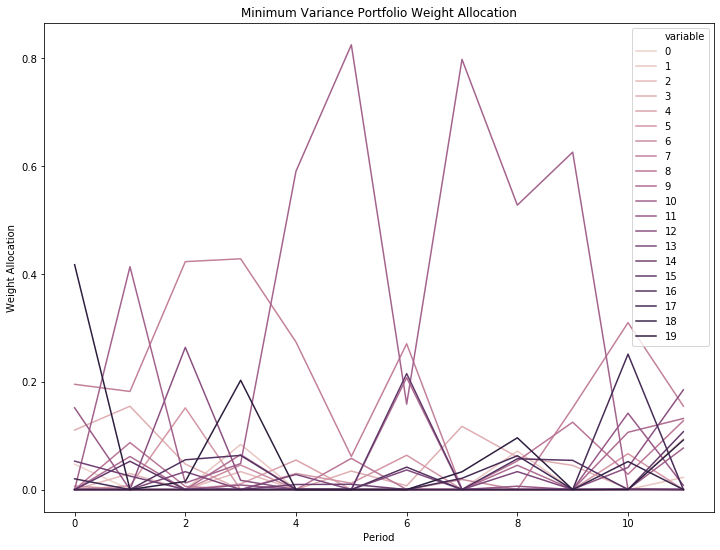

In [33]:
#sns.set_palette(sns.color_palette("hls"))
#Line Plot will be used for plotting the portfolios against one another
ax = sns.lineplot(x='Period', y='value', hue='variable', 
             data=data_2, legend='full')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='y')
ax.set_xlabel('Period')
ax.set_ylabel('Weight Allocation')
plt.title('Minimum Variance Portfolio Weight Allocation')
plt.show()

### Weight Graph for Maximum Sharpe Ratio

In [34]:
#Make new dataframe that holds the Minimum Variance Portfolio weights with columns representing periods and rows the assets
df_positions_max_sharpe = pd.DataFrame(df_positions.iloc[0,3], columns = ['Period 0'])
x = 1
for x in range (12):
    df_positions_max_sharpe["{} {}".format("Period", x+1)] = df_positions.iloc[x,3]

df_positions_max_sharpe = df_positions_max_sharpe.drop(['Period 0'], axis=1)

df_positions_max_sharpe.tail()

,Period 1,Period 2,Period 3,Period 4,Period 5,Period 6,Period 7,Period 8,Period 9,Period 10,Period 11,Period 12
15,0.0,9093.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,6556.0,17234.0,12960.0,0.0,2348.0,3539.0,4159.0,8463.0
17,0.0,490.0,28.0,0.0,967.0,513.0,278.0,0.0,299.0,0.0,155.0,0.0
18,7655.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7827.0,4700.0
19,0.0,0.0,16530.0,0.0,0.0,0.0,0.0,0.0,2218.0,0.0,0.0,0.0


In [35]:
#Setup a weights dataframe
df_weights = pd.DataFrame(columns=['Period 1', 'Period 2', 'Period 3', 'Period 4', 'Period 5', 'Period 6', 'Period 7', 'Period 8', 'Period 9', 'Period 10', 'Period 11', 'Period 12'])
df_weights.head()

,Period 1,Period 2,Period 3,Period 4,Period 5,Period 6,Period 7,Period 8,Period 9,Period 10,Period 11,Period 12


In [36]:
#Populate the weights dataframe with values for minimum variance portfolio
y = 0
for x in range (12):
    if x == 0:
        df_weights["{} {}".format("Period", x+1)] = df_price_period["{} {}".format("Period", x+1)]*df_positions_max_sharpe["{} {}".format("Period", x+1)]/df_strategies['Maximum Sharpe Ratio Portfolio'][y]
    else:
        y = x * 42
        df_weights["{} {}".format("Period", x+1)] = df_price_period["{} {}".format("Period", x+1)]*df_positions_max_sharpe["{} {}".format("Period", x+1)]/df_strategies['Maximum Sharpe Ratio Portfolio'][y]

df_weights.head(20)

,Period 1,Period 2,Period 3,Period 4,Period 5,Period 6,Period 7,Period 8,Period 9,Period 10,Period 11,Period 12
0,0.000000,0.000000,0.265623,0.000000,0.000000,0.070427,0.000000,0.000000,0.000000,0.000000,0.071651,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.073634,0.000000,0.047649,0.000000,0.200643,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.284510,0.000000,0.000000,0.000000,0.000000,0.000000,0.111186,0.000000
4,0.039961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.131508,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013100,0.000000,0.061047,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037810
7,0.000000,0.389227,0.000000,0.000000,0.000000,0.000000,0.000000,0.720382,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.174353,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120420,0.321041
9,0.000000,0.000000,0.055436,0.000000,0.000000,0.000000,0.000000,0.000000,0.088988,0.000000,0.000000,0.000000


In [37]:
#Transpose the matrix for ease of processing
df_weights = df_weights.T

In [38]:
#I will be using Seaborn for plotting, so the use of pd.melt will be required
data_2 = pd.melt(df_weights)
data_2 = data_2.reset_index()
data_2.head()
data_2 = data_2.rename(columns={"index": "Period"})
data_2['counter'] = data_2.Period

In [39]:
#Resetting the Period counter as the portfolios have been melted together into one coloumn
counter = 0
for x in range (len(data_2)):
    if (data_2.iloc[x,3]%12) == 0:
        data_2.iloc[x,0] = 0
        counter = 0
    else:
        counter = counter + 1
        data_2.iloc[x,0] = counter

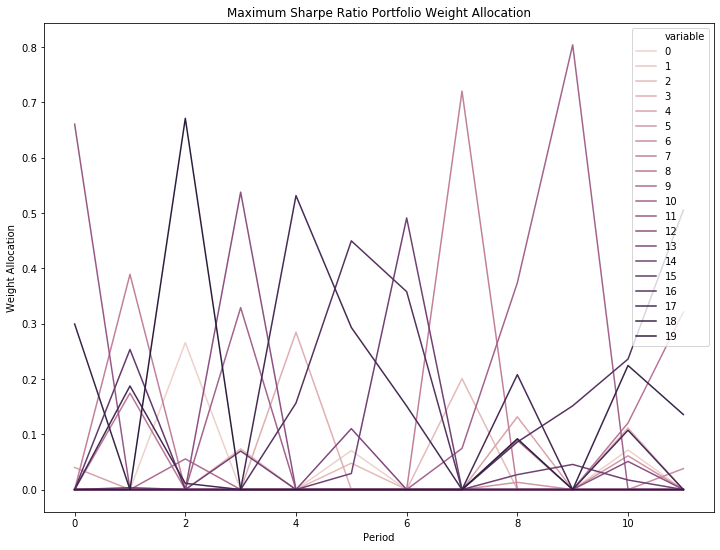

In [40]:
#sns.set_palette(sns.color_palette("hls"))
#Line Plot will be used for plotting the portfolios against one another
ax = sns.lineplot(x='Period', y='value', hue='variable', 
             data=data_2, legend='full')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='y')
ax.set_xlabel('Period')
ax.set_ylabel('Weight Allocation')
plt.title('Maximum Sharpe Ratio Portfolio Weight Allocation')
plt.show()

### Plotting The 4 Strategy Returns on One Graph

In [41]:
#Setup dataframe that holds the returns each day per strategy
df_strategies = pd.DataFrame(portf_value[0][:], columns = ['Buy and Hold']) 
df_strategies['Equally Weighted Portfolio'] = portf_value[1][:]
df_strategies['Mininum Variance Portfolio'] = portf_value[2][:]
df_strategies['Maximum Sharpe Ratio'] = portf_value[3][:]
df_strategies.tail()

,Buy and Hold,Equally Weighted Portfolio,Mininum Variance Portfolio,Maximum Sharpe Ratio
499,1.185912e+06,1.367017e+06,1.133439e+06,1.564553e+06
500,1.196778e+06,1.381280e+06,1.134483e+06,1.631311e+06
501,1.183692e+06,1.361475e+06,1.127682e+06,1.558589e+06
502,1.187130e+06,1.362029e+06,1.124291e+06,1.574924e+06
503,1.173675e+06,1.349296e+06,1.120578e+06,1.532812e+06


In [42]:
#I will be using Seaborn for plotting, so the use of pd.melt will be required
data=pd.melt(df_strategies)
data = data.reset_index()
data = data.rename(columns={"index": "Day"})
data['counter'] = data.Day

In [43]:
#Resetting the Day counter as the portfolios have been melted together into one coloumn
counter = 0
for x in range (4*len(portf_value[1][:])):
    if data.iloc[x,3] == 504:
        data.iloc[x,0] = 0
        counter = 0
    elif data.iloc[x,3] == 1008:
        data.iloc[x,0] = 0
        counter = 0
    elif data.iloc[x,3] == 1512:
        data.iloc[x,0] = 0
        counter = 0
    else:
        counter = counter + 1
        data.iloc[x,0] = counter

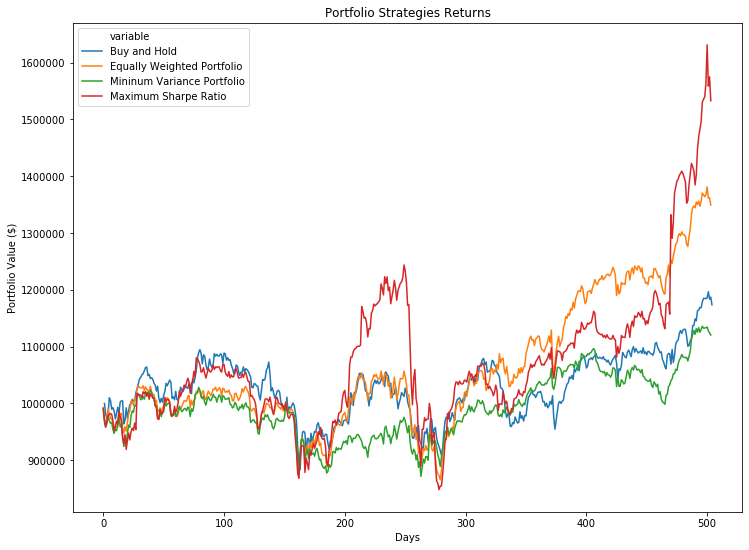

In [44]:
#Line Plot will be used for plotting the portfolios against one another
ax = sns.lineplot(x='Day', y='value', hue='variable', 
             data=data)
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='y')
ax.set_xlabel('Days')
ax.set_ylabel('Portfolio Value ($)')
plt.title('Portfolio Strategies Returns')
plt.show()